# 4. Radio Source Maps

## 4.1. Notebook setup

In [1]:
import os
import sys

from cmcrameri import cm as cmc
import emcee
from IPython import display
import matplotlib as mpl
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import smplotlib

In [2]:
epochs = ["A", "B", "C", "D", "E", "F"]
data_path = "../data/"
fig_path = "../figures/"
calibrator = "J0340"
target = "HR1099"

cm = [
    "#377eb8",
    "#e41a1c",
    "#4daf4a",
    "#dede00",
    "#ff7f00",
    "#999999",
    "#984ea3",
    "#f781bf",
    "#a65628",
]
marker_cycle = ["o", "v", "X", "<", "D", "^"]

sys.path.append(os.path.join(os.getcwd(), ".."))
from library import HR1099_astrometry, utils

deg = np.pi / 180
mas = deg / (60 * 60 * 1000)

## 4.2. Import data

In [3]:
epochs, mean_jd = np.genfromtxt(
    data_path + target + "_I_positions.txt",
    skip_header=2,
    dtype="U1,f8,f8,f8,f8,f8,f8,f8",
    usecols=(0, 5),
    unpack=True,
)
mean_mjd = np.round(mean_jd - 2400000.5, 1)

models = {}
mean_x = np.array([])
mean_y = np.array([])
for epoch in epochs:
    beam = utils.get_beam(os.path.join(data_path, f"{epoch}_{target}_sc.log"))
    models[epoch] = utils.vlb_model(
        os.path.join(data_path, f"{epoch}_{target}_sc.mod"), beam
    )
    models[epoch].excise_components(200)

    x, y, jd, x_err, y_err = np.genfromtxt(
        data_path + epoch + "_" + target + "_I_sub-epoch_positions.txt",
        skip_header=2,
        dtype="U5,f8,f8,f8,f8,f8,f8,f8",
        usecols=(2, 3, 5, 6, 7),
        unpack=True,
    )
    mean_x = np.append(mean_x, np.mean(x))
    mean_y = np.append(mean_y, np.mean(y))

sampler = emcee.backends.HDFBackend(data_path + target + "_orbital_chain.h5")
flat_samples = sampler.get_chain(flat=True)
flat_samples = np.divide(flat_samples, np.array([1, 1, deg, deg]))

med_val = np.percentile(flat_samples, [16, 50, 84], axis=0)
lower_val = med_val[1] - med_val[0]
upper_val = med_val[2] - med_val[1]
med_val = med_val[1]

hr1099 = HR1099_astrometry.HR1099_astrometry(med_val[2] * deg, med_val[3] * deg)
T0, P, d, a, m1, m2, R1, R2 = hr1099.hr1099_info()

## 4.3. Plot

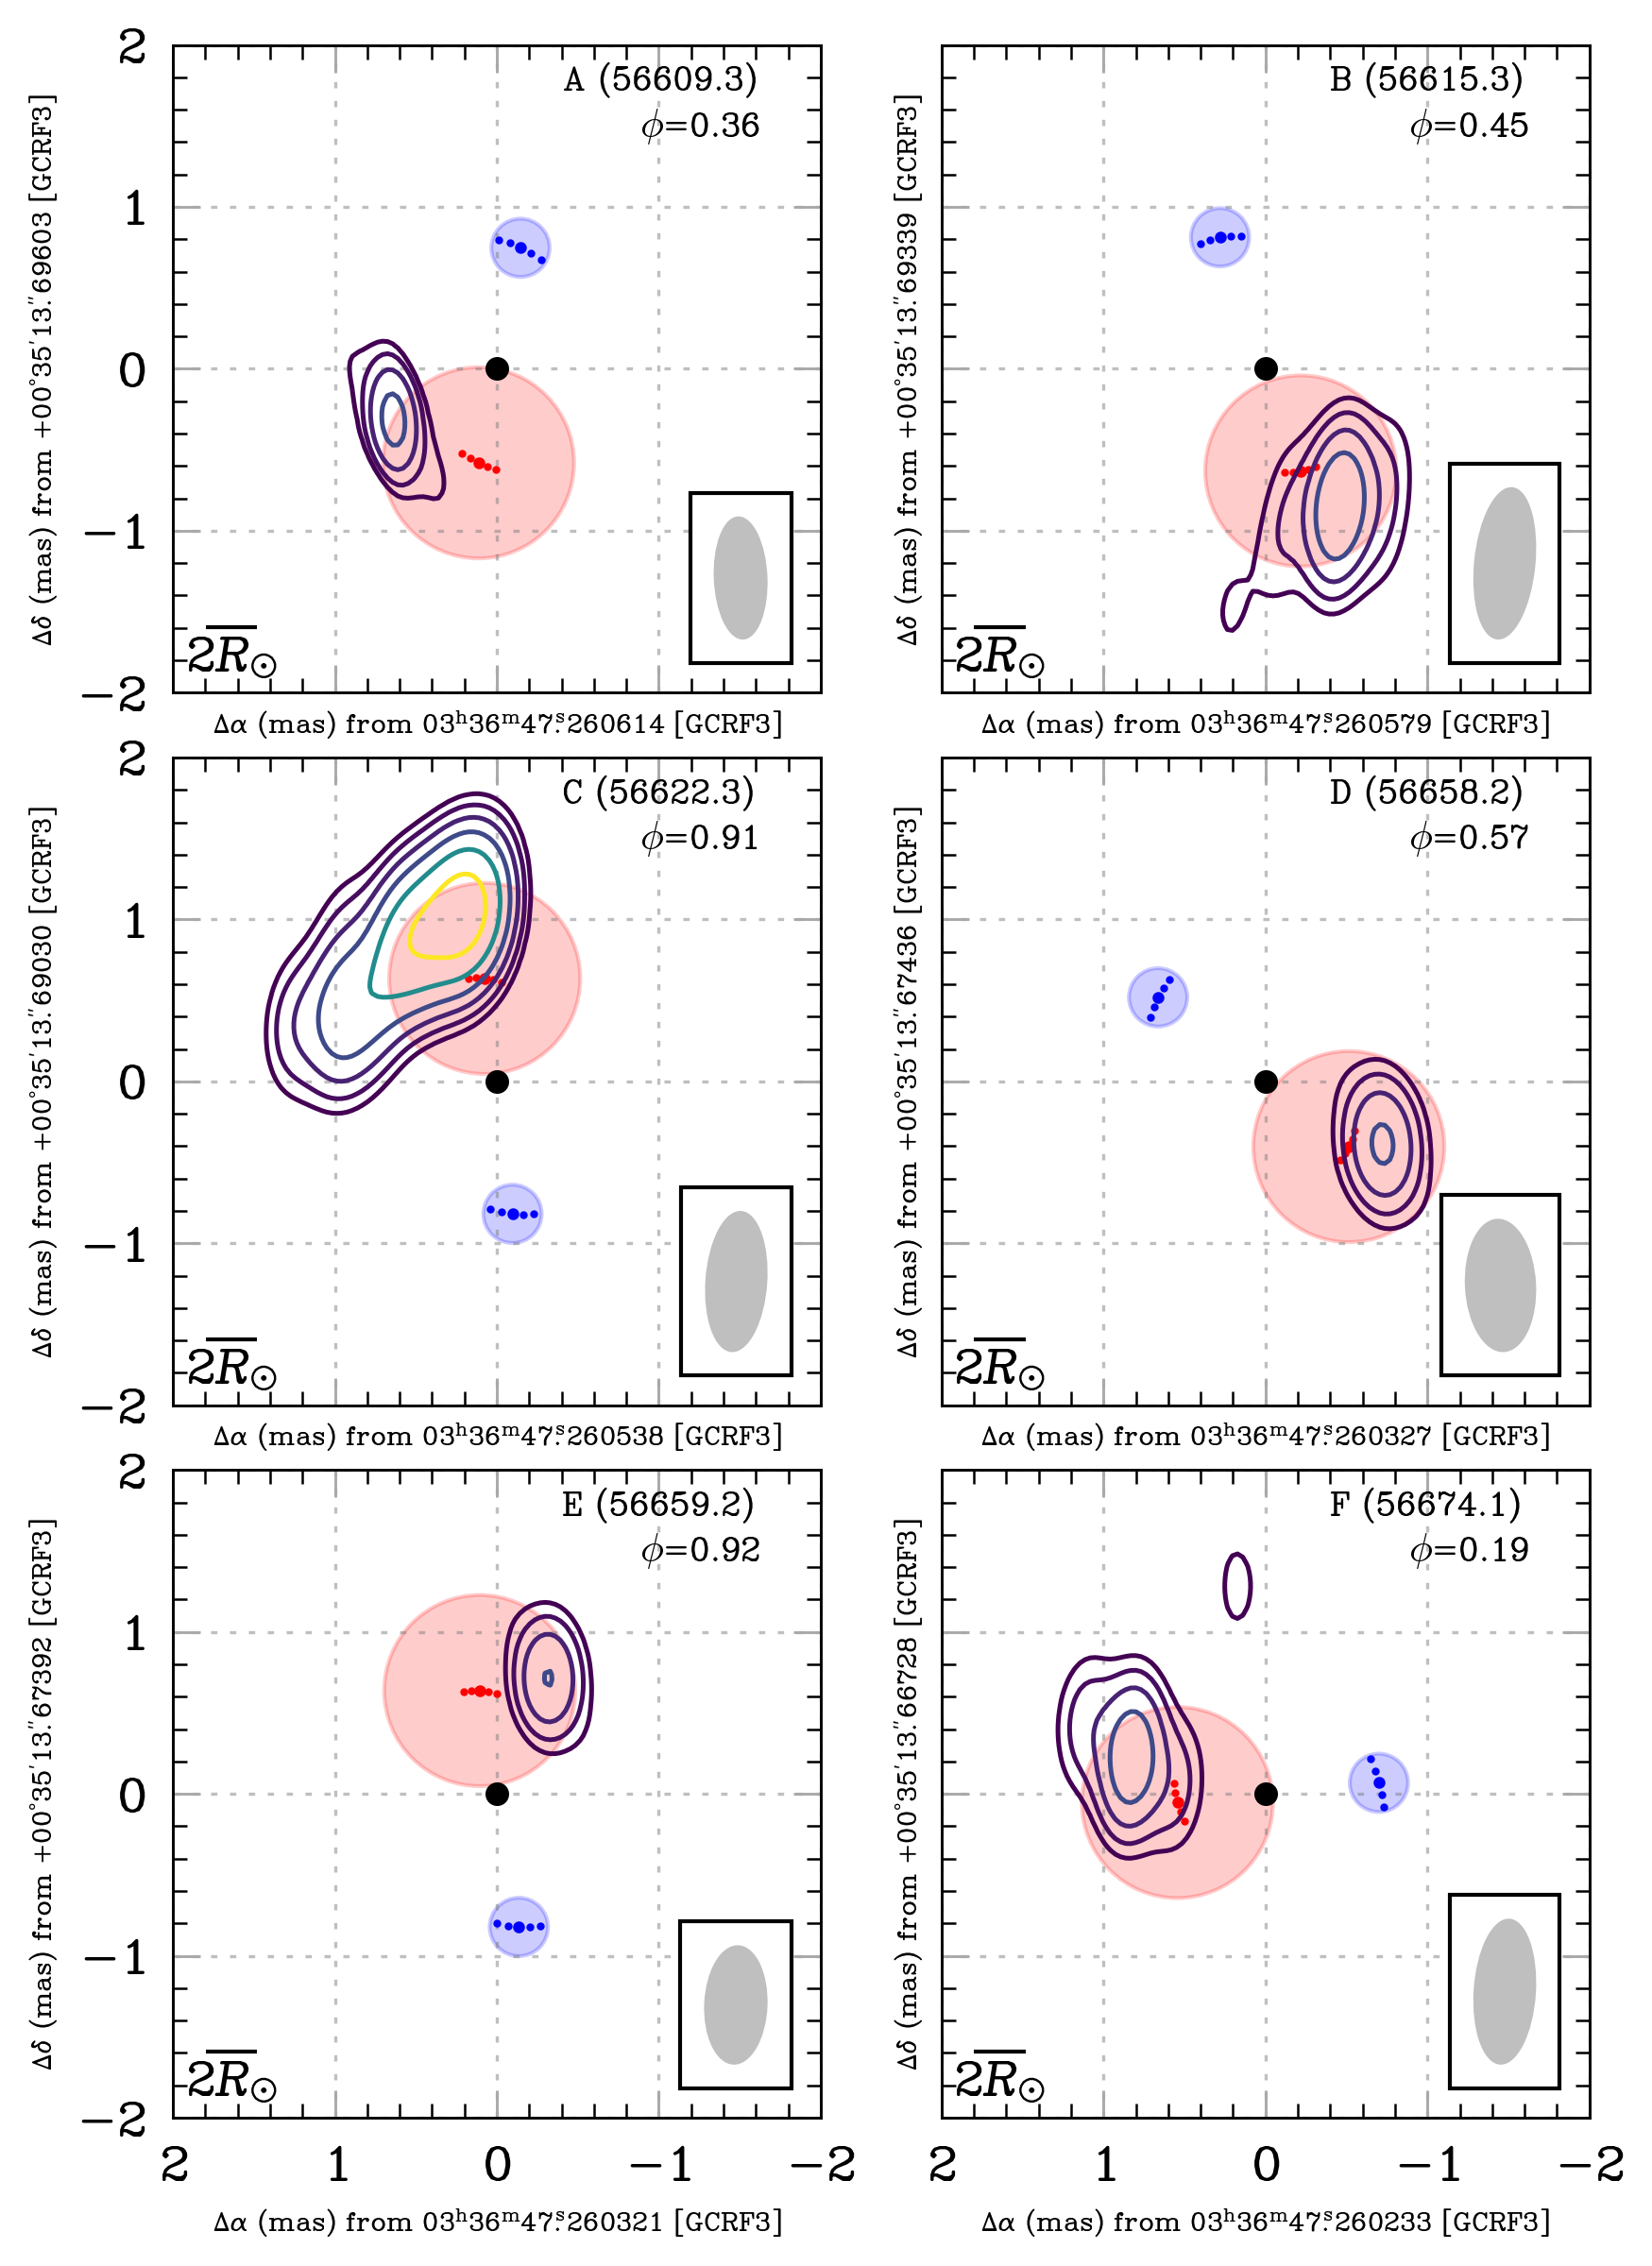

In [4]:
epoch_orbit_phases = []
for i, epoch in enumerate(epochs):
    epoch_orbit_phases.append(hr1099.orbit_phase(mean_jd[i]))
sorted_index = np.argsort(epoch_orbit_phases)

fig, ax = plt.subplots(3, 2, figsize=(7, 9.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0.1)

xx, yy = np.meshgrid(
    np.linspace(-2 * mas, 2 * mas, 256, endpoint=True),
    np.linspace(-2 * mas, 2 * mas, 256, endpoint=True),
)

model_sums = [np.sum(m.get_image_plane_model(xx, yy)) for m in models.values()]
max_lev_scalar = np.max(model_sums) / model_sums

for i, epoch in enumerate(epochs):
    utils.plot_binary(
        ax[i // 2, i % 2],
        hr1099,
        mean_jd[i],
        corotate=False,
        centroid=[mean_x[i] + med_val[0], mean_y[i] + med_val[1], 0, 0],
        label=mean_mjd[i],
        cmap="viridis",
        model=models[epoch],
        mapsize=4,
        cells=256,
        levs=[2, 4, 8, 16, 32, 64],
        max_lev_scalar=max_lev_scalar[i],
        beam=models[epoch].restoring_beam,
        show_coord_axes=True,
        hour_range=2,
        fontsize=8,
        d=d,
        bar_pos="lower left",
    )
    ax[i // 2, i % 2].annotate(
        "%s (%.1f)" % (epoch, mean_mjd[i]),
        xy=(0.6, 0.93),
        xycoords="axes fraction",
        fontsize=10,
    )
    ax[i // 2, i % 2].annotate(
        r"$\phi$=%.2f" % epoch_orbit_phases[i],
        xy=(0.72, 0.86),
        xycoords="axes fraction",
        fontsize=10,
    )
    ax[i // 2, i % 2].set_aspect("equal")
    ax[i // 2, i % 2].grid(True, linestyle="dotted", alpha=0.5)

fig.set_facecolor("white")
fig.set_dpi(300)
plt.savefig(fig_path + "radio_maps.pdf", bbox_inches="tight")
plt.show()

## 4.4. Generate movie

MovieWriter stderr:
[vost#0:0/libx264 @ 0x12e004920] Error submitting a packet to the muxer: Immediate exit requested
[out#0/mp4 @ 0x6000020dc0c0] Error muxing a packet
Received > 3 system signals, hard exiting



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1400x1400', '-pix_fmt', 'rgba', '-framerate', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '../figures/radio_maps.mp4']' returned non-zero exit status 123.

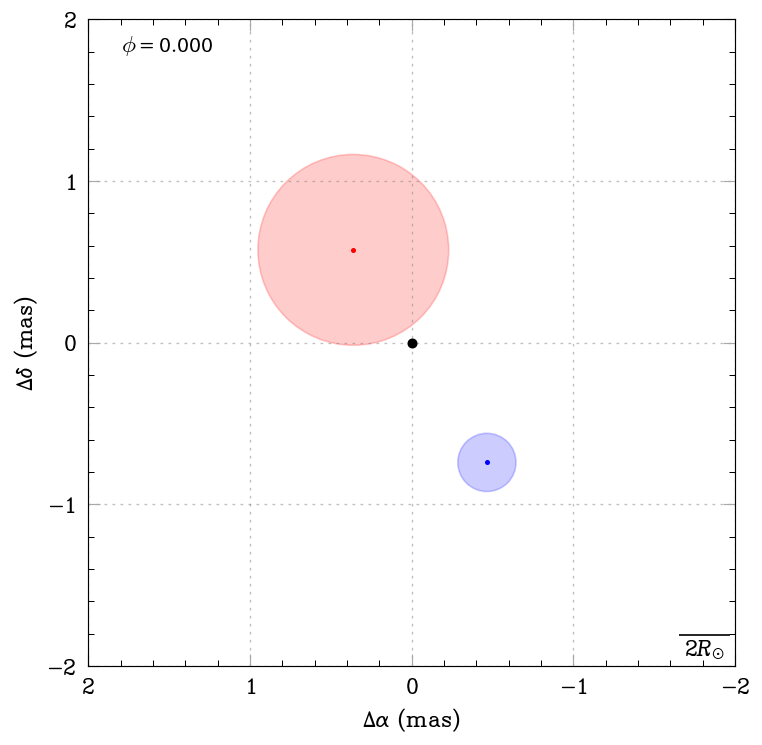

In [5]:
fps = 30  # frames per second
phaseps = 0.03  # phase per second
phase_width = 0.03  # phase width of each epoch

P = P / (24 * 3600)  # period in days

epoch_orbit_phases = []
for i, epoch in enumerate(epochs):
    epoch_orbit_phases.append(hr1099.orbit_phase(mean_jd[i]))
sorted_index = np.argsort(epoch_orbit_phases)
phase_sorted_indices = np.argsort(epoch_orbit_phases)

show_map = []
jd_range = []
for i in range(len(phase_sorted_indices)):
    start = epoch_orbit_phases[phase_sorted_indices[i]] - phase_width
    end = epoch_orbit_phases[phase_sorted_indices[i]] + phase_width

    if i == 0:
        rng = np.linspace(T0, T0 + P * start, int(fps * (start - 0) / phaseps))
        s_rng = np.zeros_like(rng)
        for j in range(len(rng)):
            jd_range.append(rng[j])
            show_map.append(s_rng[j])
    else:
        prev_end = epoch_orbit_phases[phase_sorted_indices[i - 1]] + phase_width
        if not prev_end > start:
            rng = np.linspace(
                T0 + P * prev_end,
                T0 + P * start,
                int(fps * (start - prev_end) / phaseps),
            )
            s_rng = np.zeros_like(rng)
            for j in range(len(rng)):
                jd_range.append(rng[j])
                show_map.append(s_rng[j])
        else:
            start = prev_end

    rng = np.linspace(
        T0 + P * start, T0 + P * end, int(2.5 * fps * (end - start) / phaseps)
    )
    s_rng = np.ones_like(rng)
    for j in range(len(rng)):
        jd_range.append(rng[j])
        show_map.append(s_rng[j])

    if i == len(phase_sorted_indices) - 1:
        rng = np.linspace(T0 + P * end, T0 + P, int(fps * (1 - end) / phaseps))
        s_rng = np.zeros_like(rng)
        for j in range(len(rng)):
            jd_range.append(rng[j])
            show_map.append(s_rng[j])


def show_frame(frame):
    ax.clear()
    phase = hr1099.orbit_phase(jd_range[frame])

    if show_map[frame]:
        idx = np.argmin(np.abs(epoch_orbit_phases - phase))
        utils.plot_binary(
            ax,
            hr1099,
            jd_range[frame],
            centroid=[mean_x[idx] + med_val[0], mean_y[idx] + med_val[1], 0, 0],
            label=mean_mjd[idx],
            model=models[epochs[idx]],
            mapsize=4,
            cells=256,
            levs=[4, 8, 16, 32, 64],
            beam=models[epochs[idx]].restoring_beam,
            cmap="viridis",
            d=d,
            fontsize=14,
            bar_pos="lower left",
        )
        ax.annotate(
            "MJD=%.1f" % mean_mjd[idx],
            xy=(0.05, 0.9),
            xycoords="axes fraction",
            fontsize=12,
        )
    else:
        utils.plot_binary(ax, hr1099, jd_range[frame], mapsize=4, d=d, fontsize=14)

    ax.annotate(
        r"$\phi = %.3f$" % phase, xy=(0.05, 0.95), xycoords="axes fraction", fontsize=14
    )
    ax.grid(True, linestyle="dotted", alpha=0.5)


fig, ax = plt.subplots(figsize=(7, 7))
fig.set_facecolor("white")

anim = animation.FuncAnimation(
    fig, show_frame, frames=len(jd_range), interval=1e3 / fps
)
html = anim.to_html5_video()
html = display.HTML(html)
display.display(html)
writervideo = animation.FFMpegWriter(fps=fps)
anim.save(fig_path + "radio_maps.mp4", writer=writervideo)
print("Saved animation to " + fig_path + "radio_maps.mp4")
plt.close()